## Polynomial Feature Trafo + Ridge
1. Load data and drop colinear features based on feature engineering + define same timesplits
1.5. Tune based on degree!
2. Do Ridge (L2) regression and track coefficient shrinkage
3. Do Lasso (L1) regression and track coefficient shrinkage
4. Compare and state differences

### Section 1: Load and Prepare Data & Rolling Time-Series Splits (as in the feature- engineering file)

In [1]:
# --- Step 1: Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# --- Load data ---
train_df = pd.read_csv("data/final_data_train.csv", parse_dates=["ts"])
train_df = train_df.sort_values("ts").reset_index(drop=True)

# --- Updated feature selection (same as in regularized regression) ---
selected_features = [
    "power",
    "mean_wind_speed_Nex",
    "mean_wind_speed_Hammer_ Odde_Fyr",
    "mean_temp_Hammer_Odde_Fyr",
    "DK2_DKK",
    "ImbalancePriceDKK",
    "BalancingPowerPriceUpDKK",
    "BalancingPowerPriceDownDKK",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "dayofweek"
]

# --- Prepare data ---
data = train_df[selected_features].copy()

# Split predictors and target
y = data["power"].values
X_base = data.drop(columns=["power"]).copy()

# --- Keep both wind features separately for polynomial transformation ---
wind_features = ["mean_wind_speed_Nex", "mean_wind_speed_Hammer_ Odde_Fyr"]
wind = X_base[wind_features].values           # matrix with both wind features
X_lin = X_base.drop(columns=wind_features).values  # remaining linear features
feature_names = X_base.columns.tolist()

print(f"Wind features shape: {wind.shape} (columns: {wind_features})")
print(f"Linear features shape: {X_lin.shape}")
print(f"Linear feature names: {X_base.drop(columns=wind_features).columns.tolist()}")


Wind features shape: (22422, 2) (columns: ['mean_wind_speed_Nex', 'mean_wind_speed_Hammer_ Odde_Fyr'])
Linear features shape: (22422, 10)
Linear feature names: ['mean_temp_Hammer_Odde_Fyr', 'DK2_DKK', 'ImbalancePriceDKK', 'BalancingPowerPriceUpDKK', 'BalancingPowerPriceDownDKK', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofweek']


In [2]:
# --- STEP 2: Create time-based cross-validation splits (reused) ---
def build_time_splits(ts, window="6M", horizon="1M", step=None, verbose=True):
    """
    Rolling-origin time series splits (sliding window).
    Ensures validation covers the full horizon.
    """
    import pandas as pd
    ts = pd.to_datetime(pd.Series(ts)).sort_values().reset_index(drop=True)

    if step is None:
        step = horizon

    splits = []
    split_id = 1
    start_time = ts.min()

    while True:
        train_end = start_time + pd.tseries.frequencies.to_offset(window)
        val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)

        # stop if val_end goes beyond dataset max
        if val_end > ts.max():
            break

        train_idx = ts[(ts >= start_time) & (ts < train_end)].index.values
        val_idx   = ts[(ts >= train_end) & (ts < val_end)].index.values

        if len(val_idx) == 0 or len(train_idx) == 0:
            break

        splits.append((train_idx, val_idx))

        if verbose:
            print(f"Split {split_id}:")
            print(f"  Train: {ts.iloc[train_idx[0]]} → {ts.iloc[train_idx[-1]]}")
            print(f"  Valid: {ts.iloc[val_idx[0]]} → {ts.iloc[val_idx[-1]]}")
            print(f"End {split_id}:" + "-"*40)

        start_time = start_time + pd.tseries.frequencies.to_offset(step)
        split_id += 1

    return splits
# Example usage
ts = train_df["ts"].values
time_splits = build_time_splits(ts, window="2M", horizon="1M", step="1M", verbose=True)

print(f"Created {len(time_splits)} rolling splits.")


Split 1:
  Train: 2021-01-01 00:00:00 → 2021-02-26 17:00:00
  Valid: 2021-03-01 12:00:00 → 2021-03-30 23:00:00
End 1:----------------------------------------
Split 2:
  Train: 2021-01-31 00:00:00 → 2021-03-30 23:00:00
  Valid: 2021-03-31 00:00:00 → 2021-04-29 23:00:00
End 2:----------------------------------------
Split 3:
  Train: 2021-03-01 12:00:00 → 2021-04-29 23:00:00
  Valid: 2021-04-30 00:00:00 → 2021-05-30 23:00:00
End 3:----------------------------------------
Split 4:
  Train: 2021-03-31 00:00:00 → 2021-05-30 23:00:00
  Valid: 2021-05-31 00:00:00 → 2021-06-29 23:00:00
End 4:----------------------------------------
Split 5:
  Train: 2021-04-30 00:00:00 → 2021-06-29 23:00:00
  Valid: 2021-06-30 00:00:00 → 2021-07-30 23:00:00
End 5:----------------------------------------
Split 6:
  Train: 2021-05-31 00:00:00 → 2021-07-30 23:00:00
  Valid: 2021-07-31 00:00:00 → 2021-08-30 23:00:00
End 6:----------------------------------------
Split 7:
  Train: 2021-06-30 00:00:00 → 2021-08-30 2

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/3755699785.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_end = start_time + pd.tseries.frequencies.to_offset(window)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/3755699785.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  val_end   = train_end + pd.tseries.frequencies.to_offset(horizon)
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/3755699785.py:39: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  start_time = start_time + pd.tseries.frequencies.to_offset(step)


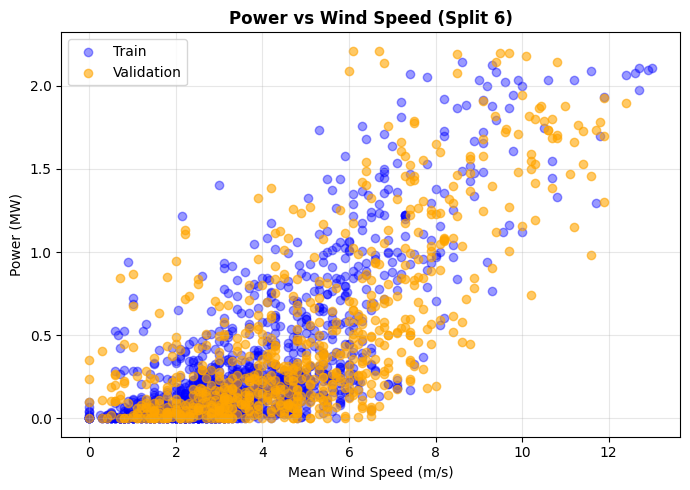

In [3]:
import matplotlib.pyplot as plt

# Pick one of your rolling splits (e.g., the first one)
split_id = 5
train_idx, val_idx = time_splits[split_id]

# Extract train and validation sets
X_train_split = train_df.iloc[train_idx]
X_val_split = train_df.iloc[val_idx]

# Plot Power vs Wind Speed
plt.figure(figsize=(7,5))
plt.scatter(X_train_split["mean_wind_speed_Nex"], X_train_split["power"],
            color="blue", alpha=0.4, label="Train")
plt.scatter(X_val_split["mean_wind_speed_Nex"], X_val_split["power"],
            color="orange", alpha=0.6, label="Validation")

plt.title(f"Power vs Wind Speed (Split {split_id+1})", fontsize=12, weight='bold')
plt.xlabel("Mean Wind Speed (m/s)")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
from itertools import product
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge_alpha = 1
degrees_to_test = [1, 2, 3, 4]
degree_pairs = list(product(degrees_to_test, repeat=2))  # all combinations

results = []

for deg_nex, deg_hammer in degree_pairs:
    fold_train_rmse, fold_val_rmse = [], []

    for train_idx, val_idx in time_splits:
        # Split data
        wind_train, wind_val = wind[train_idx], wind[val_idx]
        X_lin_train, X_lin_val = X_lin[train_idx], X_lin[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Split wind features: Nex and Hammer separately
        wind_train_nex = wind_train[:, [0]]
        wind_train_hammer = wind_train[:, [1]]
        wind_val_nex = wind_val[:, [0]]
        wind_val_hammer = wind_val[:, [1]]

        # Scale and transform Nex
        scaler_nex = StandardScaler()
        wind_train_nex_scaled = scaler_nex.fit_transform(wind_train_nex)
        wind_val_nex_scaled = scaler_nex.transform(wind_val_nex)
        poly_nex = PolynomialFeatures(degree=deg_nex, include_bias=False)
        wind_train_nex_poly = poly_nex.fit_transform(wind_train_nex_scaled)
        wind_val_nex_poly = poly_nex.transform(wind_val_nex_scaled)

        # Scale and transform Hammer
        scaler_hammer = StandardScaler()
        wind_train_hammer_scaled = scaler_hammer.fit_transform(wind_train_hammer)
        wind_val_hammer_scaled = scaler_hammer.transform(wind_val_hammer)
        poly_hammer = PolynomialFeatures(degree=deg_hammer, include_bias=False)
        wind_train_hammer_poly = poly_hammer.fit_transform(wind_train_hammer_scaled)
        wind_val_hammer_poly = poly_hammer.transform(wind_val_hammer_scaled)

        # Combine both wind polynomials
        wind_train_poly = np.hstack([wind_train_nex_poly, wind_train_hammer_poly])
        wind_val_poly = np.hstack([wind_val_nex_poly, wind_val_hammer_poly])

        # Scale linear (non-wind) features
        scaler_lin = StandardScaler()
        X_lin_train_scaled = scaler_lin.fit_transform(X_lin_train)
        X_lin_val_scaled = scaler_lin.transform(X_lin_val)

        # Combine final features
        X_train_full = np.hstack([wind_train_poly, X_lin_train_scaled])
        X_val_full = np.hstack([wind_val_poly, X_lin_val_scaled])

        # Train Ridge
        model = Ridge(alpha=ridge_alpha)
        model.fit(X_train_full, y_train)

        # Evaluate
        y_train_pred = model.predict(X_train_full)
        y_val_pred = model.predict(X_val_full)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

        fold_train_rmse.append(train_rmse)
        fold_val_rmse.append(val_rmse)

    results.append({
        "deg_nex": deg_nex,
        "deg_hammer": deg_hammer,
        "train_rmse": np.mean(fold_train_rmse),
        "val_rmse": np.mean(fold_val_rmse)
    })
    print(f"(deg_Nex={deg_nex}, deg_Hammer={deg_hammer}) → "
          f"Train RMSE={np.mean(fold_train_rmse):.3f}, Val RMSE={np.mean(fold_val_rmse):.3f}")

# --- Find best combination ---
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df["val_rmse"].idxmin()]
best_deg_nex, best_deg_hammer = int(best_row["deg_nex"]), int(best_row["deg_hammer"])

print("\n✅ Optimal polynomial degrees:")
print(f"  mean_wind_speed_Nex = {best_deg_nex}")
print(f"  mean_wind_speed_Hammer_Odde_Fyr = {best_deg_hammer}")
print(f"  Validation RMSE = {best_row['val_rmse']:.3f}")


(deg_Nex=1, deg_Hammer=1) → Train RMSE=0.284, Val RMSE=0.325
(deg_Nex=1, deg_Hammer=2) → Train RMSE=0.273, Val RMSE=0.321
(deg_Nex=1, deg_Hammer=3) → Train RMSE=0.267, Val RMSE=0.314
(deg_Nex=1, deg_Hammer=4) → Train RMSE=0.265, Val RMSE=0.313
(deg_Nex=2, deg_Hammer=1) → Train RMSE=0.275, Val RMSE=0.323
(deg_Nex=2, deg_Hammer=2) → Train RMSE=0.270, Val RMSE=0.322
(deg_Nex=2, deg_Hammer=3) → Train RMSE=0.264, Val RMSE=0.314
(deg_Nex=2, deg_Hammer=4) → Train RMSE=0.262, Val RMSE=0.314
(deg_Nex=3, deg_Hammer=1) → Train RMSE=0.266, Val RMSE=0.305
(deg_Nex=3, deg_Hammer=2) → Train RMSE=0.260, Val RMSE=0.304
(deg_Nex=3, deg_Hammer=3) → Train RMSE=0.258, Val RMSE=0.304
(deg_Nex=3, deg_Hammer=4) → Train RMSE=0.257, Val RMSE=0.306
(deg_Nex=4, deg_Hammer=1) → Train RMSE=0.265, Val RMSE=0.308
(deg_Nex=4, deg_Hammer=2) → Train RMSE=0.259, Val RMSE=0.307
(deg_Nex=4, deg_Hammer=3) → Train RMSE=0.258, Val RMSE=0.307
(deg_Nex=4, deg_Hammer=4) → Train RMSE=0.257, Val RMSE=0.308

✅ Optimal polynomial de

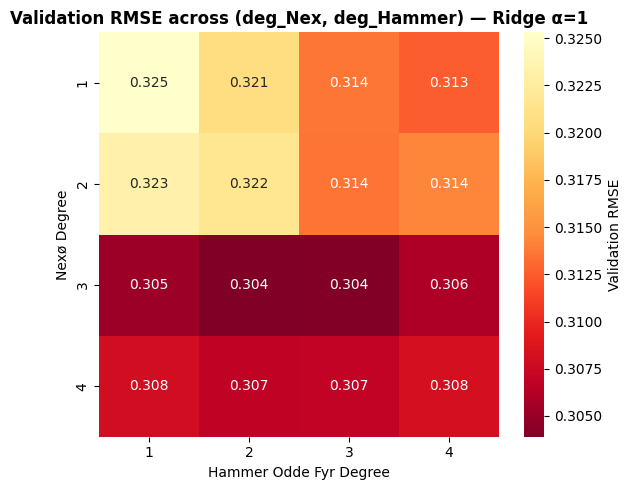

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
pivot = results_df.pivot(index="deg_nex", columns="deg_hammer", values="val_rmse")

sns.heatmap(
    pivot,
    annot=True, fmt=".3f", cmap="YlOrRd_r",
    cbar_kws={'label': 'Validation RMSE'}
)
plt.title(f"Validation RMSE across (deg_Nex, deg_Hammer) — Ridge α={ridge_alpha}", fontsize=12, weight='bold')
plt.xlabel("Hammer Odde Fyr Degree")
plt.ylabel("Nexø Degree")
plt.tight_layout()
plt.show()


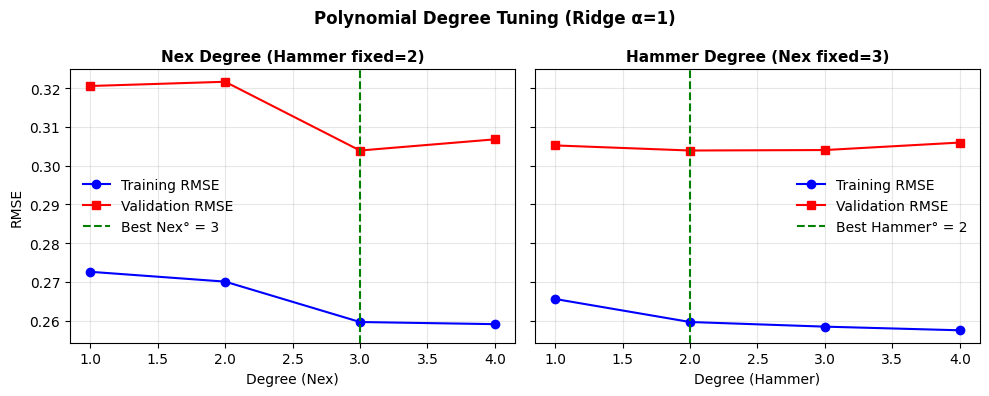

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract best combination
best_deg_nex = int(best_row["deg_nex"])
best_deg_hammer = int(best_row["deg_hammer"])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- Left: vary Nex degree (fix Hammer) ---
subset_hammer = results_df[results_df["deg_hammer"] == best_deg_hammer]
axes[0].plot(subset_hammer["deg_nex"], subset_hammer["train_rmse"], "o-", color="blue", label="Training RMSE")
axes[0].plot(subset_hammer["deg_nex"], subset_hammer["val_rmse"], "s-", color="red", label="Validation RMSE")
axes[0].axvline(best_deg_nex, color="green", linestyle="--", label=f"Best Nex° = {best_deg_nex}")
axes[0].set_title(f"Nex Degree (Hammer fixed={best_deg_hammer})", fontsize=11, weight='bold')
axes[0].set_xlabel("Degree (Nex)")
axes[0].set_ylabel("RMSE")
axes[0].grid(alpha=0.3)
axes[0].legend(frameon=False)

# --- Right: vary Hammer degree (fix Nex) ---
subset_nex = results_df[results_df["deg_nex"] == best_deg_nex]
axes[1].plot(subset_nex["deg_hammer"], subset_nex["train_rmse"], "o-", color="blue", label="Training RMSE")
axes[1].plot(subset_nex["deg_hammer"], subset_nex["val_rmse"], "s-", color="red", label="Validation RMSE")
axes[1].axvline(best_deg_hammer, color="green", linestyle="--", label=f"Best Hammer° = {best_deg_hammer}")
axes[1].set_title(f"Hammer Degree (Nex fixed={best_deg_nex})", fontsize=11, weight='bold')
axes[1].set_xlabel("Degree (Hammer)")
axes[1].grid(alpha=0.3)
axes[1].legend(frameon=False)

plt.suptitle(f"Polynomial Degree Tuning (Ridge α={ridge_alpha})", fontsize=12, weight='bold')
plt.tight_layout()
plt.show()


In [7]:
# Separate the two wind features
wind_nex = wind[:, [0]]
wind_hammer = wind[:, [1]]

# --- Polynomial transform each wind feature with its optimal degree ---
poly_nex_final = PolynomialFeatures(degree=best_deg_nex, include_bias=False)
wind_nex_poly = poly_nex_final.fit_transform(wind_nex)

poly_hammer_final = PolynomialFeatures(degree=best_deg_hammer, include_bias=False)
wind_hammer_poly = poly_hammer_final.fit_transform(wind_hammer)

# --- Combine both polynomial wind sets ---
wind_poly_full = np.hstack([wind_nex_poly, wind_hammer_poly])

# --- Scale linear (non-wind) features ---
scaler_final = StandardScaler()
X_lin_scaled_final = scaler_final.fit_transform(X_lin)

# --- Combine all predictors (wind + linear features) ---
X_train_final = np.hstack([wind_poly_full, X_lin_scaled_final])

# --- Fit final Ridge model on full training data ---
ridge_final = Ridge(alpha=ridge_alpha)
ridge_final.fit(X_train_final, y)

print(f"  Final Ridge model fitted with degrees: Nex={best_deg_nex}, Hammer={best_deg_hammer}")
print(f"  Ridge α = {ridge_alpha}")
print(f"  Final training set shape: {X_train_final.shape}")


  Final Ridge model fitted with degrees: Nex=3, Hammer=2
  Ridge α = 1
  Final training set shape: (22422, 15)


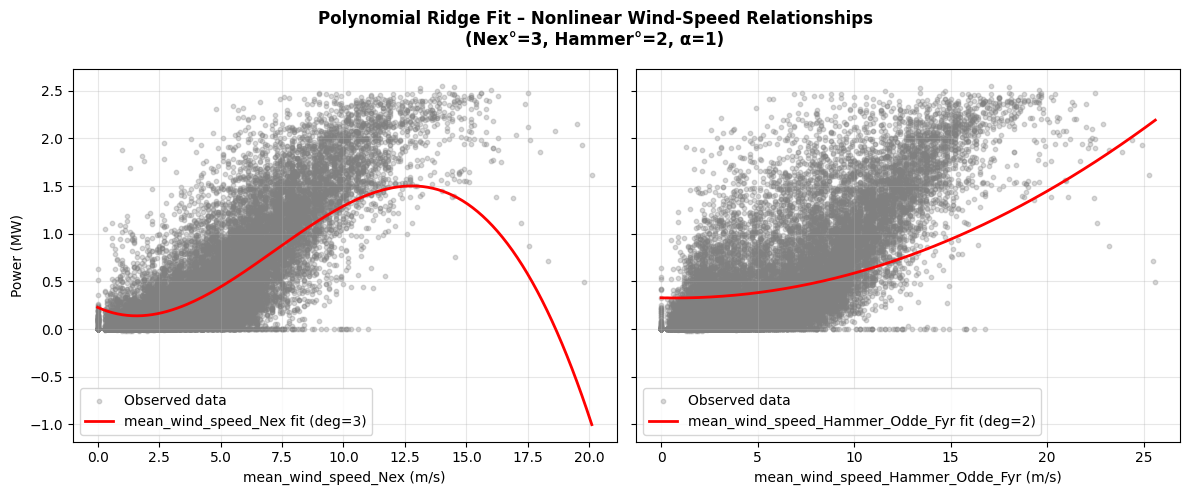

In [8]:
# --- Visualize polynomial ridge fit for each wind feature ---
import numpy as np
import matplotlib.pyplot as plt

wind_names = ["mean_wind_speed_Nex", "mean_wind_speed_Hammer_Odde_Fyr"]
wind_means = np.mean(wind, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, ax in enumerate(axes):
    # Build a smooth grid for the chosen wind feature
    wind_smooth = np.linspace(wind[:, i].min(), wind[:, i].max(), 200)
    wind_pair = np.tile(wind_means, (200, 1))
    wind_pair[:, i] = wind_smooth  # vary only one wind feature at a time

    # --- Apply polynomial transforms separately ---
    wind_nex_poly = poly_nex_final.transform(wind_pair[:, [0]])
    wind_hammer_poly = poly_hammer_final.transform(wind_pair[:, [1]])
    wind_poly_smooth = np.hstack([wind_nex_poly, wind_hammer_poly])

    # --- Use average of other (non-wind) features ---
    X_smooth = np.hstack([
        wind_poly_smooth,
        np.mean(X_lin_scaled_final, axis=0).reshape(1, -1).repeat(200, axis=0)
    ])

    # Predict
    y_smooth = ridge_final.predict(X_smooth)

    # Plot
    ax.scatter(wind[:, i], y, color="gray", alpha=0.3, s=10, label="Observed data")
    ax.plot(wind_smooth, y_smooth, color="red", linewidth=2,
            label=f"{wind_names[i]} fit (deg={best_deg_nex if i==0 else best_deg_hammer})")
    ax.set_xlabel(f"{wind_names[i]} (m/s)")
    ax.grid(alpha=0.3)
    ax.legend()

axes[0].set_ylabel("Power (MW)")
fig.suptitle(
    f"Polynomial Ridge Fit – Nonlinear Wind-Speed Relationships\n"
    f"(Nex°={best_deg_nex}, Hammer°={best_deg_hammer}, α={ridge_alpha})",
    fontsize=12, weight='bold'
)
plt.tight_layout()
plt.show()



In [9]:
test_df = pd.read_csv("data/final_data_test.csv", parse_dates=["ts"])
test_df = test_df.sort_values("ts").reset_index(drop=True)

test_data = test_df[selected_features].copy()  # same subset of columns

# Target values
y_test = test_data["power"].values

Lets try some regularization on the polynomial degree we have already to see what it yields


✅ Best λ = 14.2510, Mean Val RMSE = 0.3004
📊 Test RMSE = 0.4770


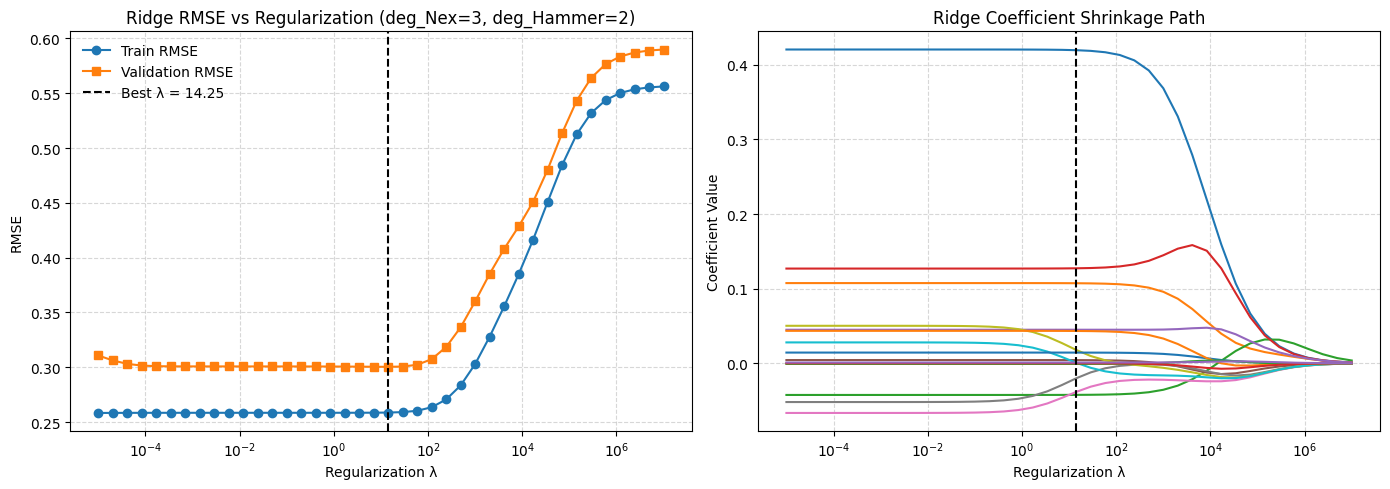

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import LogLocator
import pandas as pd

# --- Parameters ---
deg_nex, deg_hammer = best_deg_nex, best_deg_hammer
lambdas = np.logspace(-5, 7, 40)

ridge_train_rmse, ridge_val_rmse = [], []

# --- Rolling CV across time splits ---
for lam in lambdas:
    fold_train_rmse, fold_val_rmse = [], []

    for (train_idx, val_idx) in time_splits:
        # Split data
        X_train_lin, X_val_lin = X_lin[train_idx], X_lin[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # --- Extract each wind feature safely as 2D arrays ---
        wind_train_nex = wind[train_idx][:, [0]]
        wind_val_nex   = wind[val_idx][:, [0]]
        wind_train_hammer = wind[train_idx][:, [1]]
        wind_val_hammer   = wind[val_idx][:, [1]]

        # --- Scale + transform Nex wind ---
        scaler_nex = StandardScaler()
        wind_train_nex_scaled = scaler_nex.fit_transform(wind_train_nex)
        wind_val_nex_scaled   = scaler_nex.transform(wind_val_nex)

        poly_nex = PolynomialFeatures(degree=deg_nex, include_bias=False)
        wind_train_nex_poly = poly_nex.fit_transform(wind_train_nex_scaled)
        wind_val_nex_poly   = poly_nex.transform(wind_val_nex_scaled)

        # --- Scale + transform Hammer wind ---
        scaler_hammer = StandardScaler()
        wind_train_hammer_scaled = scaler_hammer.fit_transform(wind_train_hammer)
        wind_val_hammer_scaled   = scaler_hammer.transform(wind_val_hammer)

        poly_hammer = PolynomialFeatures(degree=deg_hammer, include_bias=False)
        wind_train_hammer_poly = poly_hammer.fit_transform(wind_train_hammer_scaled)
        wind_val_hammer_poly   = poly_hammer.transform(wind_val_hammer_scaled)

        # Combine polynomial wind features
        wind_train_poly = np.hstack([wind_train_nex_poly, wind_train_hammer_poly])
        wind_val_poly   = np.hstack([wind_val_nex_poly, wind_val_hammer_poly])

        # --- Scale linear (non-wind) features ---
        lin_scaler = StandardScaler()
        X_train_lin_scaled = lin_scaler.fit_transform(X_train_lin)
        X_val_lin_scaled   = lin_scaler.transform(X_val_lin)

        # Combine all features
        X_train_full = np.hstack([wind_train_poly, X_train_lin_scaled])
        X_val_full   = np.hstack([wind_val_poly, X_val_lin_scaled])

        # --- Fit Ridge model ---
        model = Ridge(alpha=lam)
        model.fit(X_train_full, y_train)

        # --- Predict ---
        y_train_pred = np.clip(model.predict(X_train_full), 0, None)
        y_val_pred   = np.clip(model.predict(X_val_full), 0, None)

        # --- RMSE ---
        fold_train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        fold_val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

    ridge_train_rmse.append(np.mean(fold_train_rmse))
    ridge_val_rmse.append(np.mean(fold_val_rmse))

# --- Optimal λ ---
best_lambda_idx = np.argmin(ridge_val_rmse)
best_lambda = lambdas[best_lambda_idx]
print(f"\n✅ Best λ = {best_lambda:.4f}, Mean Val RMSE = {ridge_val_rmse[best_lambda_idx]:.4f}")

# --- Retrain on full training data ---
scaler_nex_full = StandardScaler().fit(wind[:, [0]])
scaler_hammer_full = StandardScaler().fit(wind[:, [1]])
poly_nex_full = PolynomialFeatures(degree=deg_nex, include_bias=False).fit(scaler_nex_full.transform(wind[:, [0]]))
poly_hammer_full = PolynomialFeatures(degree=deg_hammer, include_bias=False).fit(scaler_hammer_full.transform(wind[:, [1]]))

wind_nex_poly_full = poly_nex_full.transform(scaler_nex_full.transform(wind[:, [0]]))
wind_hammer_poly_full = poly_hammer_full.transform(scaler_hammer_full.transform(wind[:, [1]]))
wind_poly_full = np.hstack([wind_nex_poly_full, wind_hammer_poly_full])

scaler_lin_full = StandardScaler().fit(X_lin)
X_lin_scaled_full = scaler_lin_full.transform(X_lin)

X_full = np.hstack([wind_poly_full, X_lin_scaled_full])

ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(X_full, y)

# --- Prepare test data ---
wind_test_nex = test_df[["mean_wind_speed_Nex"]].values
wind_test_hammer = test_df[["mean_wind_speed_Hammer_ Odde_Fyr"]].values
y_test = test_df["power"].values

# Select the same linear columns as training
lin_feature_names = X_base.drop(columns=["mean_wind_speed_Nex", "mean_wind_speed_Hammer_ Odde_Fyr"]).columns.tolist()
X_test_lin = test_df[lin_feature_names].values

# Apply same transformers from training
wind_test_nex_poly = poly_nex_full.transform(scaler_nex_full.transform(wind_test_nex))
wind_test_hammer_poly = poly_hammer_full.transform(scaler_hammer_full.transform(wind_test_hammer))
wind_test_poly = np.hstack([wind_test_nex_poly, wind_test_hammer_poly])
X_test_lin_scaled = scaler_lin_full.transform(X_test_lin)
X_test_full = np.hstack([wind_test_poly, X_test_lin_scaled])

# --- Predict + Evaluate ---
y_test_pred = np.clip(ridge_best.predict(X_test_full), 0, None)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"📊 Test RMSE = {test_rmse:.4f}")

# --- Coefficient shrinkage paths ---
coefs = []
for lam in lambdas:
    ridge_tmp = Ridge(alpha=lam)
    ridge_tmp.fit(X_full, y)
    coefs.append(ridge_tmp.coef_)
coefs = np.array(coefs)

# --- Plot RMSE + Coefficient Shrinkage ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].semilogx(lambdas, ridge_train_rmse, "o-", label="Train RMSE")
axes[0].semilogx(lambdas, ridge_val_rmse, "s-", label="Validation RMSE")
axes[0].axvline(best_lambda, color="k", linestyle="--", label=f"Best λ = {best_lambda:.2f}")
axes[0].set_title(f"Ridge RMSE vs Regularization (deg_Nex={deg_nex}, deg_Hammer={deg_hammer})")
axes[0].set_xlabel("Regularization λ")
axes[0].set_ylabel("RMSE")
axes[0].legend(frameon=False)
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))

axes[1].semilogx(lambdas, coefs)
axes[1].axvline(best_lambda, color="k", linestyle="--")
axes[1].set_title("Ridge Coefficient Shrinkage Path")
axes[1].set_xlabel("Regularization λ")
axes[1].set_ylabel("Coefficient Value")
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].xaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0,)))

plt.tight_layout()
plt.show()


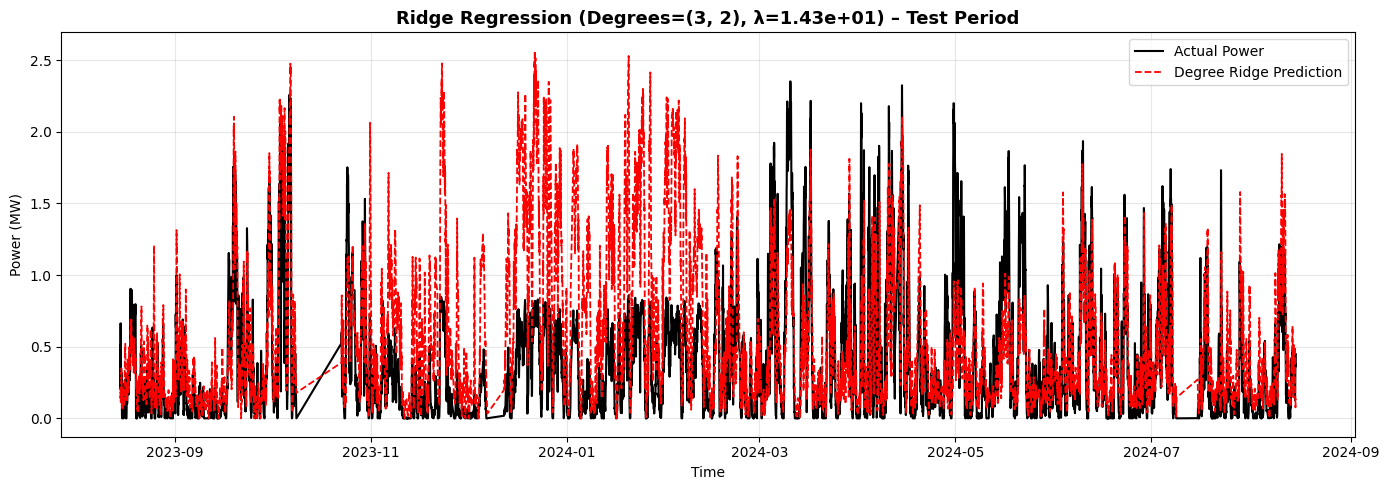

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(test_df["ts"], y_test, "k-", label="Actual Power", linewidth=1.5)
plt.plot(test_df["ts"], y_test_pred, "r--", label="Degree Ridge Prediction", linewidth=1.3)

plt.title(f"Ridge Regression (Degrees={deg_nex, deg_hammer}, λ={best_lambda:.2e}) – Test Period", fontsize=13, weight='bold')
plt.xlabel("Time")
plt.ylabel("Power (MW)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

✅ Best month: {'year': 2023.0, 'month': 8.0, 'RMSE': 0.20473851717641883}
❌ Worst month: {'year': 2023.0, 'month': 12.0, 'RMSE': 0.8397298864819265}


/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/1612307483.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.sqrt(mean_squared_error(df["Actual"], df["Ridge"])))
/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/1612307483.py:48: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonaswiendl/local/Repos/assignment-1-awesome/ml_assignment1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


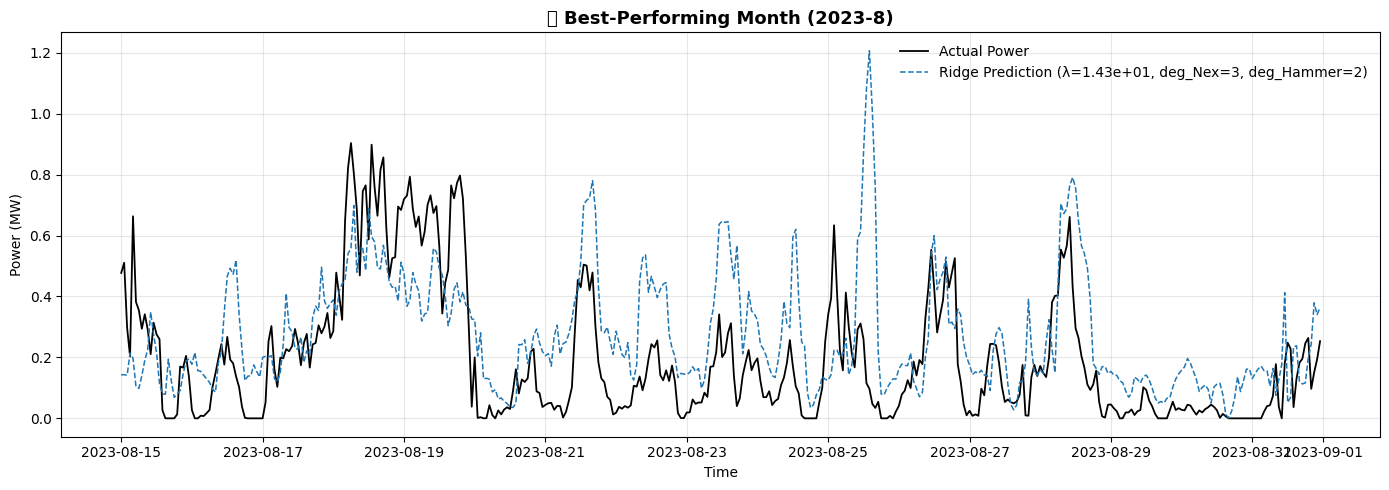

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_91377/1612307483.py:48: UserWarning: Glyph 127785 (\N{CLOUD WITH LIGHTNING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/jonaswiendl/local/Repos/assignment-1-awesome/ml_assignment1/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127785 (\N{CLOUD WITH LIGHTNING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


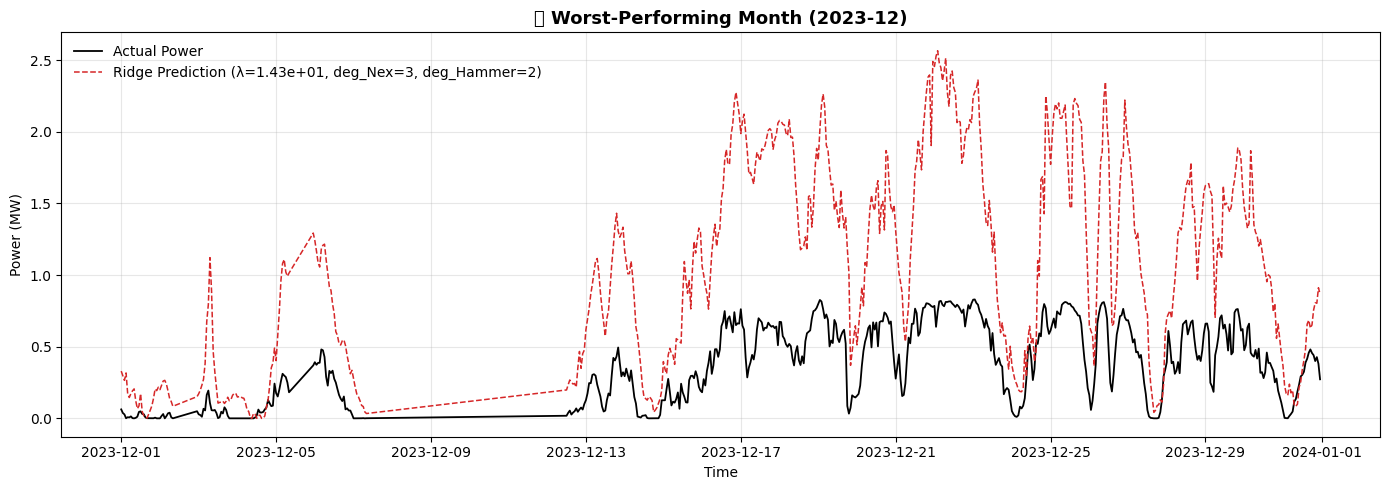

In [12]:


# --- Ensure timestamp column is datetime ---
if not np.issubdtype(test_df["ts"].dtype, np.datetime64):
    test_df["ts"] = pd.to_datetime(test_df["ts"])

# --- Build results DataFrame ---
results_plot = pd.DataFrame({
    "ts": test_df["ts"],
    "Actual": y_test,
    "Ridge": y_test_pred
})

# Extract year/month for grouping
results_plot["year"] = results_plot["ts"].dt.year
results_plot["month"] = results_plot["ts"].dt.month

# --- Compute RMSE per month ---
monthly_rmse = (
    results_plot
    .groupby(["year", "month"], as_index=False)
    .apply(lambda df: np.sqrt(mean_squared_error(df["Actual"], df["Ridge"])))
    .rename(columns={None: "RMSE"})
    .reset_index(drop=True)
)

# --- Identify best and worst months ---
best_month = monthly_rmse.loc[monthly_rmse["RMSE"].idxmin()]
worst_month = monthly_rmse.loc[monthly_rmse["RMSE"].idxmax()]

print("✅ Best month:", best_month.to_dict())
print("❌ Worst month:", worst_month.to_dict())

# --- Helper function for plotting ---
def plot_month(df, year, month, title, color="tab:red"):
    month_data = df[(df["year"] == year) & (df["month"] == month)].copy()
    if month_data.empty:
        print(f"⚠️ No data available for {year}-{month}.")
        return
    plt.figure(figsize=(14, 5))
    plt.plot(month_data["ts"], month_data["Actual"], "k-", label="Actual Power", linewidth=1.3)
    plt.plot(month_data["ts"], month_data["Ridge"], "--", color=color,
             label=f"Ridge Prediction (λ={best_lambda:.2e}, deg_Nex={best_deg_nex}, deg_Hammer={best_deg_hammer})",
             linewidth=1.1)
    plt.title(title, fontsize=13, weight="bold")
    plt.xlabel("Time")
    plt.ylabel("Power (MW)")
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Plot best and worst months ---
plot_month(
    results_plot,
    int(best_month["year"]),
    int(best_month["month"]),
    f"🌤️ Best-Performing Month ({int(best_month['year'])}-{int(best_month['month'])})",
    color="tab:blue"
)

plot_month(
    results_plot,
    int(worst_month["year"]),
    int(worst_month["month"]),
    f"🌩️ Worst-Performing Month ({int(worst_month['year'])}-{int(worst_month['month'])})",
    color="tab:red"
)



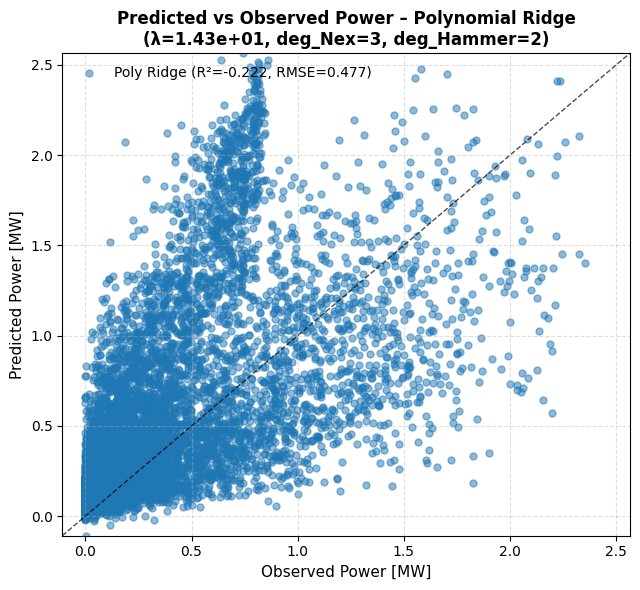

In [13]:

from sklearn.metrics import r2_score, mean_squared_error


# --- Predict using final model ---
y_pred_poly = ridge_best.predict(X_test_full)

# --- Compute metrics ---
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

# --- Diagonal limits ---
min_val = min(y_test.min(), y_pred_poly.min())
max_val = max(y_test.max(), y_pred_poly.max())
lims = [min_val, max_val]

# --- Plot ---
plt.figure(figsize=(6.5, 6))
plt.scatter(y_test, y_pred_poly, alpha=0.5, s=25,
            label=f"Poly Ridge (R²={r2_poly:.3f}, RMSE={rmse_poly:.3f})",
            color="#1f77b4")

# Diagonal reference line (perfect prediction)
plt.plot(lims, lims, 'k--', lw=1, alpha=0.7)

# Axis & styling
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Observed Power [MW]", fontsize=11)
plt.ylabel("Predicted Power [MW]", fontsize=11)
plt.title(f"Predicted vs Observed Power – Polynomial Ridge\n"
          f"(λ={best_lambda:.2e}, deg_Nex={best_deg_nex}, deg_Hammer={best_deg_hammer})",
          fontsize=12, weight='bold')
plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


In [14]:
def profit(p_commit, p_real, price_da, price_up, price_down):
    """
    Compute total profit for a set of decisions and prices.

    Parameters
    ----------
    p_commit : np.ndarray
        Committed power in the day-ahead market (decision variable, can be continuous between 0 and capacity).
    p_real : np.ndarray
        Realized wind production (truth).
    price_da : np.ndarray
        Day-ahead price (DKK/MWh).
    price_up : np.ndarray
        Up-regulation price (DKK/MWh).
    price_down : np.ndarray
        Down-regulation price (DKK/MWh).

    Returns
    -------
    float
        total profit over all time steps.
    """
    # Positive imbalance: produced more than committed (sell extra at down price)
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    # Negative imbalance: produced less than committed (buy shortage at up price)
    imbalance_neg = np.maximum(p_commit - p_real, 0)

    R_D = np.sum(price_da * p_commit)
    R_B = np.sum(price_down * imbalance_pos - price_up * imbalance_neg)

    return R_D + R_B

In [15]:
# --- STEP 4: Profitability Analysis (Polynomial Ridge Only) ---
import numpy as np
import pandas as pd

# === TRAIN PERIOD ===
price_DA_train   = train_df["DK2_DKK"].values
price_UP_train   = train_df["BalancingPowerPriceUpDKK"].values
price_DOWN_train = train_df["BalancingPowerPriceDownDKK"].values
p_real_train     = train_df["power"].values

# --- Model prediction (train) ---
y_pred_poly_train = ridge_best.predict(X_full)

# --- Compute profits ---
profit_real_train = profit(p_real_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)
profit_poly_train = profit(y_pred_poly_train, p_real_train, price_DA_train, price_UP_train, price_DOWN_train)


# === TEST PERIOD ===
price_DA_test   = test_df["DK2_DKK"].values
price_UP_test   = test_df["BalancingPowerPriceUpDKK"].values
price_DOWN_test = test_df["BalancingPowerPriceDownDKK"].values
p_real_test     = test_df["power"].values

# --- Model prediction (test) ---
y_pred_poly_test = ridge_best.predict(X_test_full)

# --- Compute profits ---
profit_real_test = profit(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_poly_test = profit(y_pred_poly_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)


# --- Summarize ---
summary = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Perfect Info (Real Power)": [profit_real_train, profit_real_test],
    "Polynomial Ridge": [profit_poly_train, profit_poly_test]
})

summary["Poly Ridge / Perfect [%]"] = (
    100 * summary["Polynomial Ridge"] / summary["Perfect Info (Real Power)"]
)

print("💰 Profitability Summary (DKK):")
display(summary.round(2))


💰 Profitability Summary (DKK):


,Dataset,Perfect Info (Real Power),Polynomial Ridge,Poly Ridge / Perfect [%]
0,Train,7911643.12,7433617.84,93.96
1,Test,1082036.68,861018.43,79.57


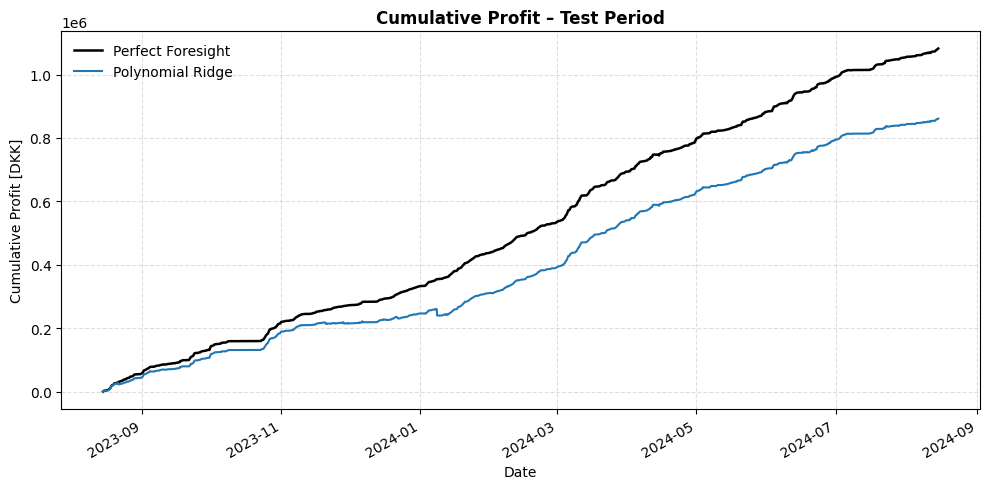

In [16]:
def profit_series(p_commit, p_real, price_da, price_up, price_down):
    imbalance_pos = np.maximum(p_real - p_commit, 0)
    imbalance_neg = np.maximum(p_commit - p_real, 0)
    return price_da * p_commit + price_down * imbalance_pos - price_up * imbalance_neg

# Compute per-timestep profit for test set
profit_real_ts = profit_series(p_real_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)
profit_poly_ts = profit_series(y_pred_poly_test, p_real_test, price_DA_test, price_UP_test, price_DOWN_test)

cum_profit = pd.DataFrame({
    "ts": test_df["ts"],
    "Perfect": np.cumsum(profit_real_ts),
    "Poly Ridge": np.cumsum(profit_poly_ts)
})

plt.figure(figsize=(10,5))
plt.plot(cum_profit["ts"], cum_profit["Perfect"], color="black", lw=1.8, label="Perfect Foresight")
plt.plot(cum_profit["ts"], cum_profit["Poly Ridge"], color="#1f77b4", lw=1.5, label="Polynomial Ridge")
plt.title("Cumulative Profit – Test Period", fontsize=12, weight='bold')
plt.xlabel("Date")
plt.ylabel("Cumulative Profit [DKK]")
plt.legend(frameon=False)
plt.grid(alpha=0.4, linestyle='--')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

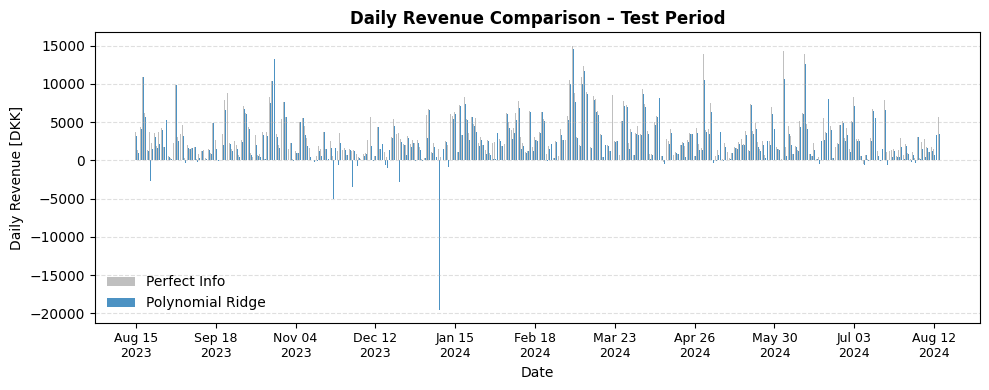

In [17]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Daily total revenue (from your previous step) ---
rev_daily = pd.DataFrame({
    "Date": pd.to_datetime(test_df["ts"]).dt.normalize(),  # ensure daily datetimes
    "Perfect Info": profit_real_ts,
    "Polynomial Ridge": profit_poly_ts
}).groupby("Date").sum().reset_index()

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 4))

bar_width = 0.4
x = np.arange(len(rev_daily))

ax.bar(x - bar_width/2, rev_daily["Perfect Info"], width=bar_width,
       color="gray", alpha=0.5, label="Perfect Info")
ax.bar(x + bar_width/2, rev_daily["Polynomial Ridge"], width=bar_width,
       color="#1f77b4", alpha=0.8, label="Polynomial Ridge")

ax.set_title("Daily Revenue Comparison – Test Period", fontsize=12, weight='bold')
ax.set_ylabel("Daily Revenue [DKK]")
ax.legend(frameon=False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# --- Fix x-axis date formatting ---
ax.set_xlabel("Date")
ax.set_xticks(x[::max(1, len(x)//10)])  # show about 10 evenly spaced ticks
ax.set_xticklabels(
    [d.strftime("%b %d\n%Y") for d in rev_daily["Date"][::max(1, len(x)//10)]],
    rotation=0, ha="center", fontsize=9
)

plt.tight_layout()
plt.show()



In [18]:
test_results = {
    "model_name": "Polynomial Ridge",
    "y_test": p_real_test,
    "y_test_pred": y_pred_poly,
    "test_rmse": rmse_poly,
}

In [19]:
# --- Export Results for Polynomial Ridge ---
import pandas as pd, os

os.makedirs("Results", exist_ok=True)

# Save full test predictions
pd.DataFrame({
    "ts": test_df["ts"],
    "y_test": test_results["y_test"],
    "y_pred": test_results["y_test_pred"]
}).to_csv("Results/polynomial_ridge_predictions.csv", index=False)

# Save summary metrics
pd.DataFrame([{
    "model": test_results["model_name"],
    "test_rmse": float(test_results["test_rmse"])
}]).to_csv("Results/polynomial_ridge_summary.csv", index=False)

print("✅ Exported Polynomial Ridge results to 'Results/' folder.")


✅ Exported Polynomial Ridge results to 'Results/' folder.
